In [51]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [52]:
df = pd.read_csv("./data/aggregate_data.csv")

In [53]:
# Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    indices = []
    for i in range(len(data) - sequence_length):
        sequence = data[i : i + sequence_length]
        # print(sequence)
        target = data[i + sequence_length]
        sequences.append(sequence)
        targets.append(target)
        indices.append(i)
    return np.array(sequences), np.array(targets), np.array(indices)

In [54]:
# Define sequence length
sequence_length = 5

# Create sequences for each ID
sequences = []
targets = []
all_indices = []
for id, group in df.groupby('experimenter'):
    id_sequences, id_targets, id_indices = create_sequences(group['stress_level'].values, sequence_length)
    sequences.append(id_sequences)
    targets.append(id_targets)
    all_indices.append(group.index[id_indices])
    
X = np.vstack(sequences)
y = np.hstack(targets)
indices = np.hstack(all_indices)
# scaler = StandardScaler()
# scaler = scaler.fit(X)
# X = scaler.transform(X)

In [55]:
def train_test_split_by_experimenter(X, y, data: pd.DataFrame, experimenter_name: str):
    """
    Splits the features and target into training and testing sets based on the experimenter.
    
    Parameters:
    X (pd.DataFrame or np.ndarray): The feature DataFrame or array.
    y (pd.Series or np.ndarray): The target Series or array.
    data (pd.DataFrame): The input DataFrame containing a column named 'experimenter'.
    experimenter_name (str): The name of the experimenter to filter by.
    
    Returns:
    pd.DataFrame or np.ndarray, pd.DataFrame or np.ndarray, pd.Series or np.ndarray, pd.Series or np.ndarray:
    X_train, X_test, y_train, y_test
    """
    # Check if the 'experimenter' column exists in the DataFrame
    if 'experimenter' not in data.columns:
        raise ValueError("The input DataFrame must contain a column named 'experimenter'.")
    
    # Identify the indices for the specified experimenter and the others
    experimenter_indices = data[data['experimenter'] == experimenter_name].index
    test_indices = np.where(np.isin(indices, experimenter_indices))[0]
    train_indices = np.where(~np.isin(indices, experimenter_indices))[0]
    
    # Split the features and target into training and testing sets
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

In [56]:
X_train, X_test, y_train, y_test = train_test_split_by_experimenter(X, y, df, 'Kiara')

In [57]:
X_train

array([[2, 3, 3, 3, 3],
       [3, 3, 3, 3, 2],
       [3, 3, 3, 2, 1],
       ...,
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2]])

In [58]:
def create_model(units=128, dropout_rate=0.2, learning_rate=0.0001):
    model = Sequential([
        LSTM(units=units, input_shape=(sequence_length, 1), activation='relu'),
        Dropout(dropout_rate),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [38]:
def fine_tune_model(X_train, y_train, X_test, y_test):
    model = KerasClassifier(model=create_model, verbose=0)

    # Define the grid of hyperparameters to search
    param_grid = {
        'model__units': [64, 128, 256],
        'model__dropout_rate': [0.1, 0.2, 0.3],
        'batch_size': [16, 32, 64],
        'epochs': [10, 20],
        'model__learning_rate': [0.0001, 0.001]
    }

    # Create the GridSearchCV object
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)
    
    # Fit the grid search to the data
    grid_result = grid.fit(X_train, y_train)

    # Print the results
    print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, std, param in zip(means, stds, params):
        print(f"{mean} ({std}) with: {param}")

    # Return the best model
    return grid_result.best_estimator_.model_

In [39]:
sequence_length = X_train.shape[1]

model = fine_tune_model(X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/Users/aledpro/anaconda3/envs/kglab/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/aledpro/anaconda3/envs/kglab/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/aledpro/anaconda3/envs/kglab/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/aledpro/anaconda3/envs/kglab/lib/python3.9/site-packages/keras/

Best: 0.7221269296740996 using {'batch_size': 16, 'epochs': 20, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.001, 'model__units': 64}
0.6841052029731275 (0.016635033191510728) with: {'batch_size': 16, 'epochs': 10, 'model__dropout_rate': 0.1, 'model__learning_rate': 0.0001, 'model__units': 64}
0.6952544311034877 (0.01015570021059552) with: {'batch_size': 16, 'epochs': 10, 'model__dropout_rate': 0.1, 'model__learning_rate': 0.0001, 'model__units': 128}
0.7115494568324757 (0.006315243577579929) with: {'batch_size': 16, 'epochs': 10, 'model__dropout_rate': 0.1, 'model__learning_rate': 0.0001, 'model__units': 256}
0.7181246426529446 (0.01138496726800447) with: {'batch_size': 16, 'epochs': 10, 'model__dropout_rate': 0.1, 'model__learning_rate': 0.001, 'model__units': 64}
0.7206975414522584 (0.012054413174561452) with: {'batch_size': 16, 'epochs': 10, 'model__dropout_rate': 0.1, 'model__learning_rate': 0.001, 'model__units': 128}
0.7158376214979989 (0.004918424966862561) with: {'bat

In [47]:
model = create_model(units=64, dropout_rate=0.3, learning_rate=0.001)

/Users/aledpro/anaconda3/envs/kglab/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4740 - loss: 1.1670 - val_accuracy: 0.4815 - val_loss: 1.1264
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6132 - loss: 0.9338 - val_accuracy: 0.7450 - val_loss: 0.8996
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6327 - loss: 0.8969 - val_accuracy: 0.7762 - val_loss: 0.7495
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6492 - loss: 0.9150 - val_accuracy: 0.7751 - val_loss: 0.6869
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6637 - loss: 0.8628 - val_accuracy: 0.7767 - val_loss: 0.6848
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6583 - loss: 0.8803 - val_accuracy: 0.7757 - val_loss: 0.6779
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6683 - loss: 0.8703 - val_accuracy: 0.7714 - val_loss: 0.6737
Epoch 8/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6628 - loss: 0.8767 - val_accuracy: 0.

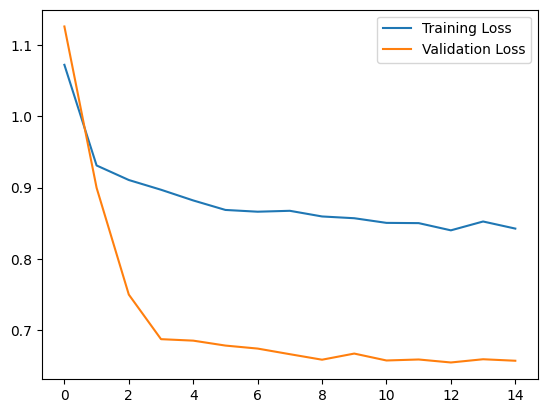

In [49]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()

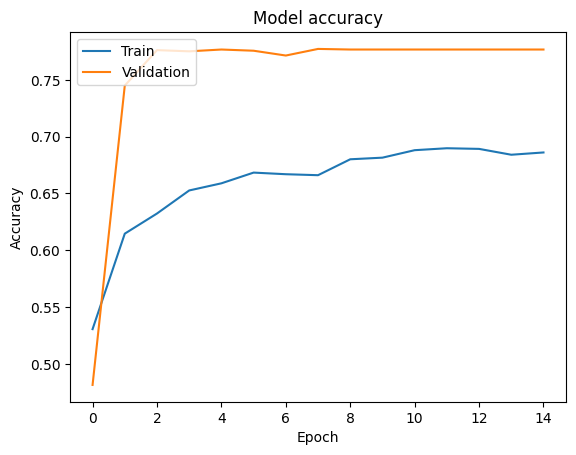

In [50]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [44]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) 

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [45]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

Accuracy: 0.7767195767195767
Precision: 0.7767261203656963
Recall: 0.7767195767195767
F1 Score: 0.7767225062504607
ROC-AUC: 0.901218144925638


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step


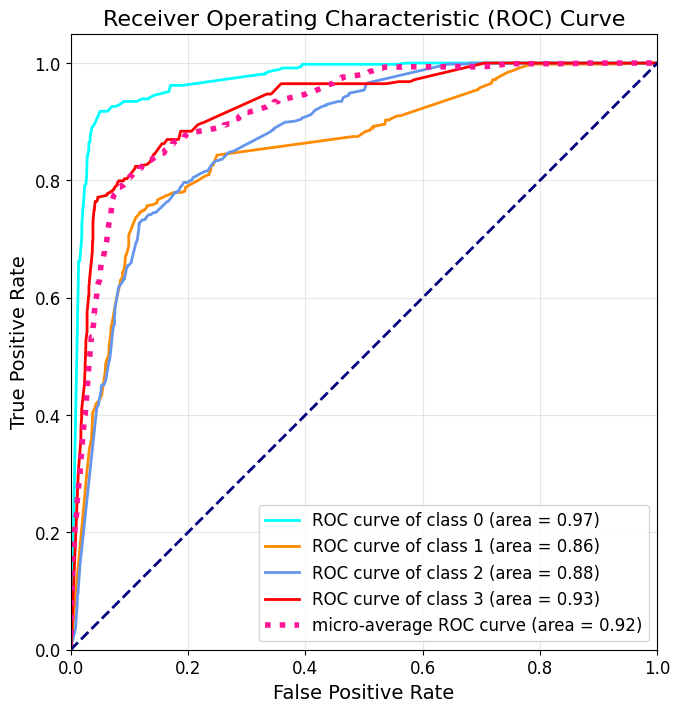

In [46]:
y_pred_probs = model.predict(X_test)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))
    
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()